In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()  # See deepshape.curves.curves for definition.
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap(c2), Qmap(c1)
# q, r = SRVT(c2), SRVT(c1)

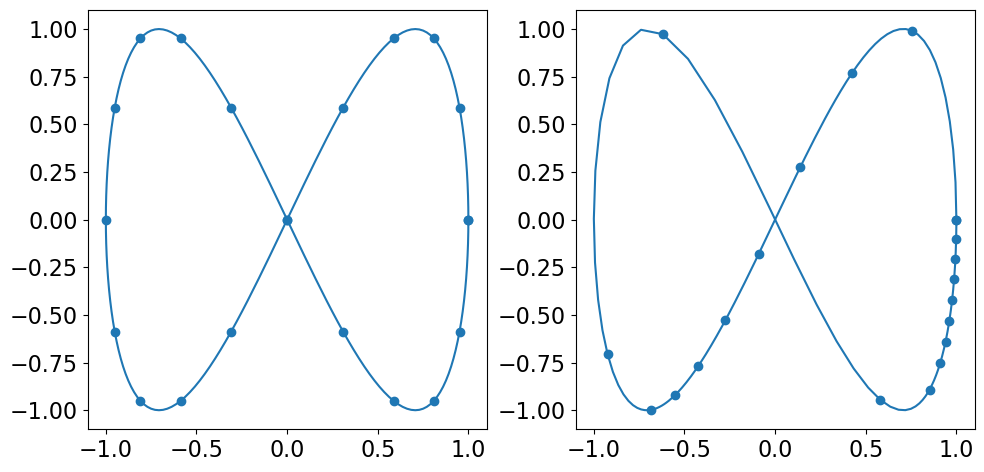

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

[Iter     1] loss: 9.421726
[Iter     6] loss: 1.995411
[Iter    11] loss: 0.095757
[Iter    16] loss: 0.054527
[Iter    21] loss: 0.051924
[Iter    26] loss: 0.042677
[Iter    31] loss: 0.038251
[Iter    36] loss: 0.034395
[Iter    41] loss: 0.028976
[Iter    46] loss: 0.021555
[Iter    51] loss: 0.017860

Finished training in 0.21251s


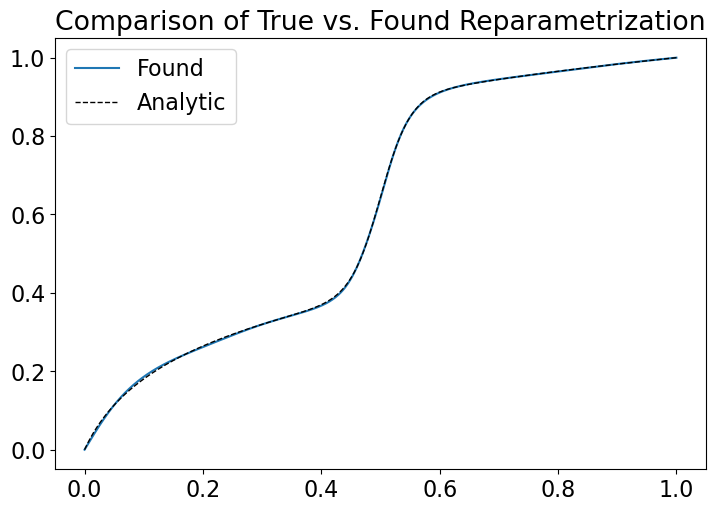

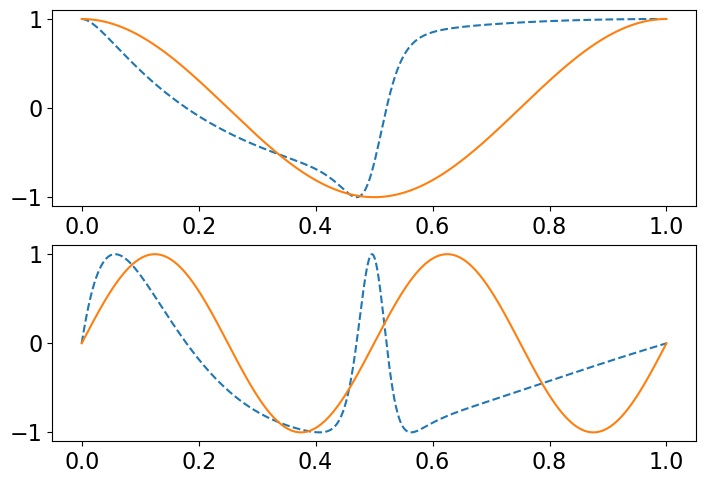

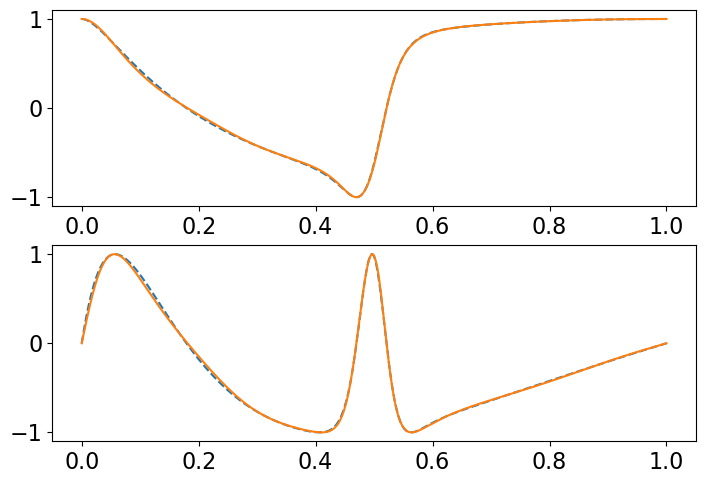

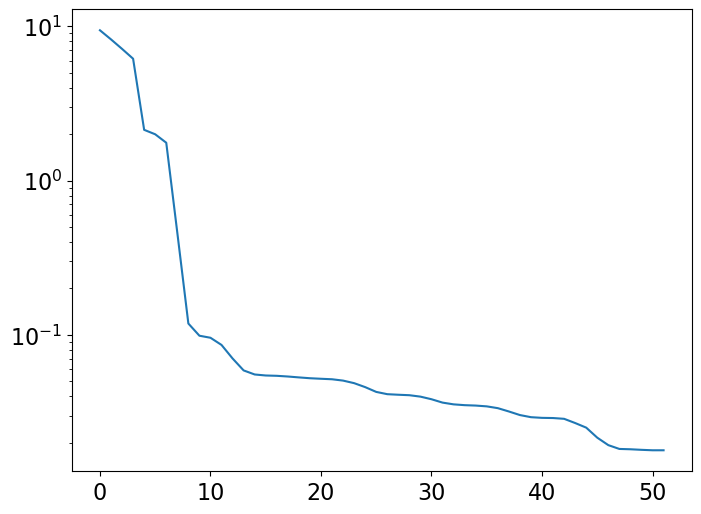

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(5) for _ in range(5)
])

# Define loss function
loss_func = CurveDistance(q, r, k=128)



# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-2)

# Learning Rate Scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=1, threshold=0.,
#     threshold_mode='rel', cooldown=1, min_lr=1e-6, eps=1e-08,
#     verbose=True)

# q, r = q, 

# Train with BFGS-optimizer
error = reparametrize(RN, loss_func, optimizer, 100, Logger(5), projection_kwargs={"p": 1})#, scheduler=scheduler)

# RN.to("cpu")
# loss_func.to("cpu")

x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()

__Repeated using GPU (if available) for a large network takes more time, but allows very small errors.__

[Iter     1] loss: 9.442791
[Iter     6] loss: 1.147560
[Iter    11] loss: 0.246619
[Iter    16] loss: 0.028921
[Iter    21] loss: 0.001111
[Iter    26] loss: 0.000020
[Iter    31] loss: 0.000005
[Iter    36] loss: 0.000003
[Iter    41] loss: 0.000002
[Iter    46] loss: 0.000002
[Iter    51] loss: 0.000002

Finished training in 9.76657s


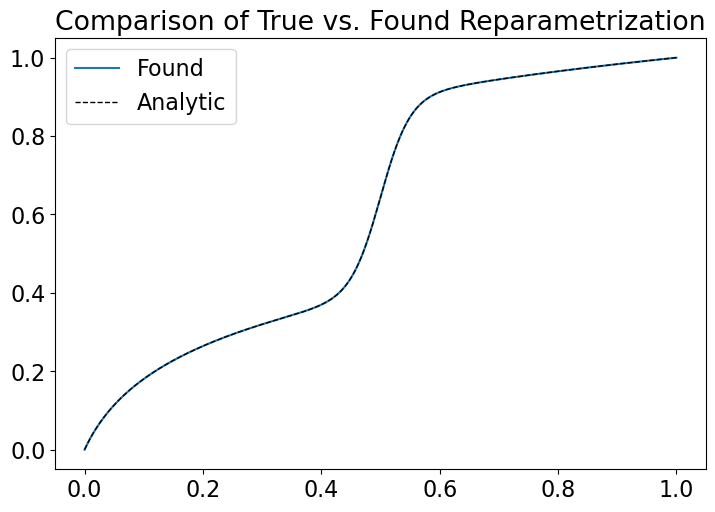

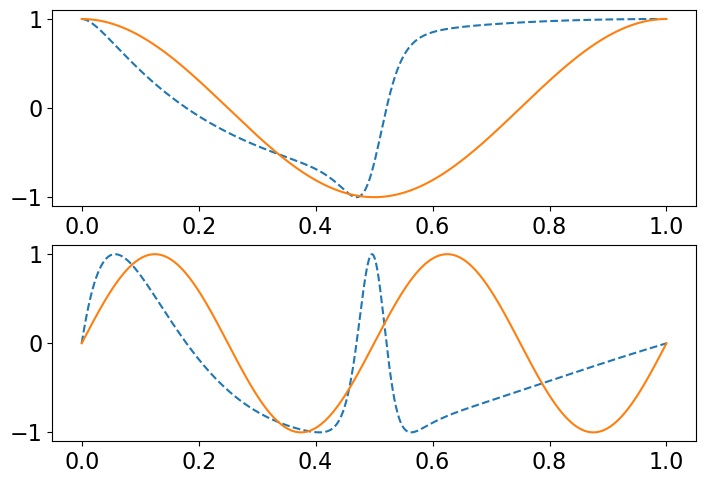

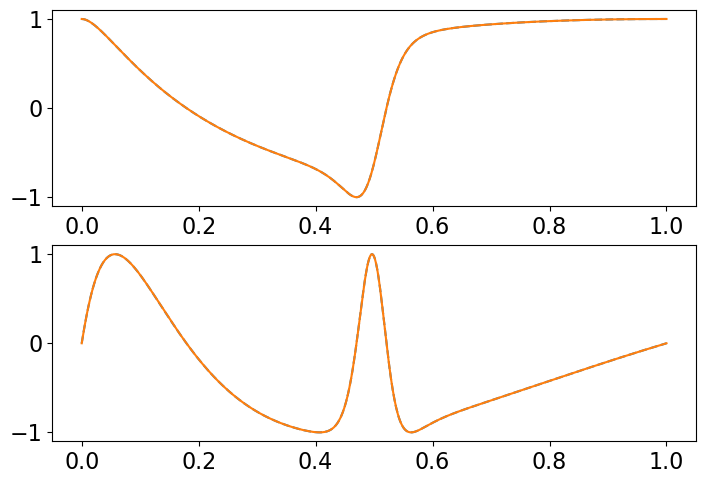

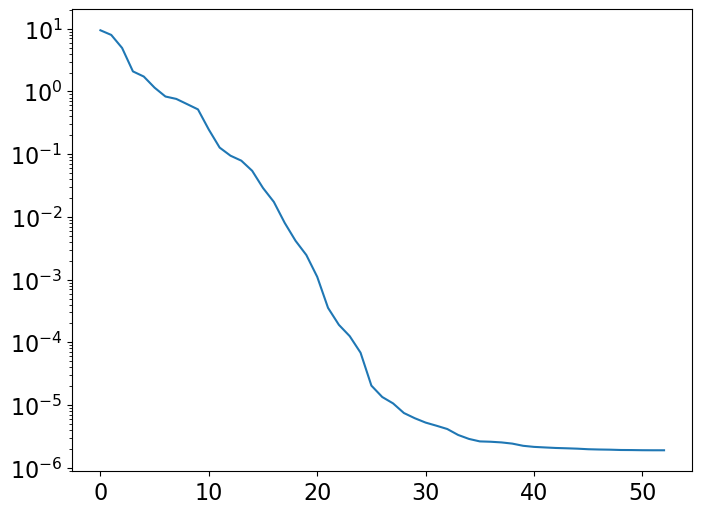

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create reparametrization network
RN = CurveReparametrizer([
    SineSeries(100) for _ in range(100)
]).to(device)

# Define loss function
loss_func = CurveDistance(q, r, k=2048).to(device)

# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=200, line_search_fn='strong_wolfe')
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = reparametrize(RN, loss_func, optimizer, 100, Logger(5))#, scheduler=scheduler)

RN.to("cpu")
loss_func.to("cpu")

x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()

plt.figure()
plt.semilogy(error)
plt.show()